In [1]:
# =========================
# Notebook Cell 1: Imports
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)


In [2]:
# ==========================================
# Notebook Cell 2: Helper functions (KPIs)
# ==========================================
def safe_div(a, b):
    """Safe divide: returns NaN if denominator is 0 or missing."""
    a = np.array(a, dtype="float64")
    b = np.array(b, dtype="float64")
    out = np.full_like(a, np.nan, dtype="float64")
    mask = b != 0
    out[mask] = a[mask] / b[mask]
    return out

def clamp01(x):
    """Clamp to [0, 1]."""
    return np.clip(x, 0, 1)

def minmax(series):
    """Min-max scale series to [0,1]. Handles constant series."""
    s = series.astype(float)
    if s.nunique(dropna=True) <= 1:
        return pd.Series(np.ones(len(s))*0.5, index=s.index)  # neutral
    return (s - s.min()) / (s.max() - s.min())

def zscore_to_unit(series):
    """Convert z-score to approx [0,1] via logistic transform."""
    s = series.astype(float)
    z = (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) != 0 else 1.0)
    return 1 / (1 + np.exp(-z))  # logistic

def compute_nps(promoters, detractors, total_respondents):
    """
    NPS = %promoters - %detractors, on [-100, 100]
    """
    p = safe_div(promoters, total_respondents) * 100
    d = safe_div(detractors, total_respondents) * 100
    return p - d

def churn_rate(customers_lost, customers_start):
    """Monthly/period churn rate in %."""
    return safe_div(customers_lost, customers_start) * 100

def profit_margin(net_profit, revenue):
    """Net profit margin in %."""
    return safe_div(net_profit, revenue) * 100

def operating_cash_coverage(op_cash_flow, operating_expenses):
    """Cash flow coverage ratio: >1 means op cash covers op expenses."""
    return safe_div(op_cash_flow, operating_expenses)

def current_ratio(current_assets, current_liabilities):
    """Current ratio: >1 is generally healthy; context matters."""
    return safe_div(current_assets, current_liabilities)

def recurring_revenue_ratio(recurring_rev, total_rev):
    """Recurring revenue share in %."""
    return safe_div(recurring_rev, total_rev) * 100


In [3]:
# ==========================================================
# Notebook Cell 3: Sample datasets (UK BBQ houses & Carvery)
# ==========================================================
bbq_data = [
    # NOTE: These are fictional sample figures for analytics demos.
    {"business": "Smoke & Oak - Manchester", "segment": "BBQ House",
     "revenue_gbp": 1_800_000, "cogs_gbp": 720_000, "opex_gbp": 820_000, "net_profit_gbp": 160_000,
     "op_cash_flow_gbp": 210_000, "current_assets_gbp": 380_000, "current_liabilities_gbp": 240_000,
     "recurring_rev_gbp": 240_000,  # e.g., catering contracts / events / corporate repeat
     "promoters": 380, "detractors": 60, "survey_total": 520,
     "customers_start": 22_000, "customers_lost": 1_500,
     "reputation_score_10": 8.6, "market_share_growth_pct": 2.1, "uvp_score_10": 8.0,
     "waste_pct": 5.2, "labour_pct": 29.0, "table_turns_per_day": 2.7,
     "kpi_maturity_10": 7.0, "adaptability_10": 8.0,
     "engagement_10": 7.8, "annual_turnover_pct": 18.0, "training_hours_per_employee": 22, "leadership_10": 8.2},

    {"business": "Pitmaster Yard - London", "segment": "BBQ House",
     "revenue_gbp": 3_200_000, "cogs_gbp": 1_350_000, "opex_gbp": 1_550_000, "net_profit_gbp": 210_000,
     "op_cash_flow_gbp": 190_000, "current_assets_gbp": 520_000, "current_liabilities_gbp": 510_000,
     "recurring_rev_gbp": 310_000,
     "promoters": 610, "detractors": 140, "survey_total": 900,
     "customers_start": 44_000, "customers_lost": 4_200,
     "reputation_score_10": 8.1, "market_share_growth_pct": 1.2, "uvp_score_10": 7.6,
     "waste_pct": 6.7, "labour_pct": 33.5, "table_turns_per_day": 3.1,
     "kpi_maturity_10": 8.5, "adaptability_10": 7.2,
     "engagement_10": 7.1, "annual_turnover_pct": 28.0, "training_hours_per_employee": 18, "leadership_10": 7.5},

    {"business": "Coal & Brisket - Leeds", "segment": "BBQ House",
     "revenue_gbp": 1_250_000, "cogs_gbp": 520_000, "opex_gbp": 620_000, "net_profit_gbp": 75_000,
     "op_cash_flow_gbp": 95_000, "current_assets_gbp": 250_000, "current_liabilities_gbp": 180_000,
     "recurring_rev_gbp": 150_000,
     "promoters": 240, "detractors": 55, "survey_total": 360,
     "customers_start": 15_500, "customers_lost": 1_300,
     "reputation_score_10": 8.4, "market_share_growth_pct": 1.7, "uvp_score_10": 7.9,
     "waste_pct": 5.9, "labour_pct": 30.2, "table_turns_per_day": 2.4,
     "kpi_maturity_10": 6.2, "adaptability_10": 7.8,
     "engagement_10": 7.6, "annual_turnover_pct": 20.0, "training_hours_per_employee": 16, "leadership_10": 7.9},
]

carvery_data = [
    # Fictional sample figures for analytics demos.
    {"business": "Sunday Roast Co. - Birmingham", "segment": "Carvery",
     "revenue_gbp": 2_400_000, "cogs_gbp": 900_000, "opex_gbp": 1_180_000, "net_profit_gbp": 190_000,
     "op_cash_flow_gbp": 240_000, "current_assets_gbp": 410_000, "current_liabilities_gbp": 260_000,
     "recurring_rev_gbp": 380_000,  # e.g., group bookings, events, loyalty repeat
     "promoters": 520, "detractors": 70, "survey_total": 700,
     "customers_start": 30_000, "customers_lost": 1_800,
     "reputation_score_10": 8.8, "market_share_growth_pct": 2.6, "uvp_score_10": 8.1,
     "waste_pct": 4.4, "labour_pct": 28.2, "table_turns_per_day": 2.9,
     "kpi_maturity_10": 7.4, "adaptability_10": 7.6,
     "engagement_10": 8.0, "annual_turnover_pct": 16.0, "training_hours_per_employee": 24, "leadership_10": 8.0},

    {"business": "The Great Carve - Bristol", "segment": "Carvery",
     "revenue_gbp": 1_950_000, "cogs_gbp": 820_000, "opex_gbp": 980_000, "net_profit_gbp": 110_000,
     "op_cash_flow_gbp": 135_000, "current_assets_gbp": 330_000, "current_liabilities_gbp": 290_000,
     "recurring_rev_gbp": 270_000,
     "promoters": 410, "detractors": 95, "survey_total": 650,
     "customers_start": 25_000, "customers_lost": 2_400,
     "reputation_score_10": 8.0, "market_share_growth_pct": 1.0, "uvp_score_10": 7.2,
     "waste_pct": 5.1, "labour_pct": 31.0, "table_turns_per_day": 2.6,
     "kpi_maturity_10": 6.5, "adaptability_10": 7.0,
     "engagement_10": 7.2, "annual_turnover_pct": 24.0, "training_hours_per_employee": 14, "leadership_10": 7.1},

    {"business": "Yorkshire Carvery House - York", "segment": "Carvery",
     "revenue_gbp": 1_400_000, "cogs_gbp": 560_000, "opex_gbp": 720_000, "net_profit_gbp": 80_000,
     "op_cash_flow_gbp": 105_000, "current_assets_gbp": 240_000, "current_liabilities_gbp": 170_000,
     "recurring_rev_gbp": 210_000,
     "promoters": 300, "detractors": 70, "survey_total": 480,
     "customers_start": 18_500, "customers_lost": 1_850,
     "reputation_score_10": 8.3, "market_share_growth_pct": 1.4, "uvp_score_10": 7.7,
     "waste_pct": 4.8, "labour_pct": 29.5, "table_turns_per_day": 2.5,
     "kpi_maturity_10": 6.8, "adaptability_10": 7.4,
     "engagement_10": 7.7, "annual_turnover_pct": 19.0, "training_hours_per_employee": 20, "leadership_10": 7.6},
]

df = pd.DataFrame(bbq_data + carvery_data)
df.head()


,business,segment,revenue_gbp,cogs_gbp,opex_gbp,net_profit_gbp,op_cash_flow_gbp,current_assets_gbp,current_liabilities_gbp,recurring_rev_gbp,promoters,detractors,survey_total,customers_start,customers_lost,reputation_score_10,market_share_growth_pct,uvp_score_10,waste_pct,labour_pct,table_turns_per_day,kpi_maturity_10,adaptability_10,engagement_10,annual_turnover_pct,training_hours_per_employee,leadership_10
0,Smoke & Oak - Manchester,BBQ House,1800000,720000,820000,160000,210000,380000,240000,240000,380,60,520,22000,1500,8.6,2.1,8.0,5.2,29.0,2.7,7.0,8.0,7.8,18.0,22,8.2
1,Pitmaster Yard - London,BBQ House,3200000,1350000,1550000,210000,190000,520000,510000,310000,610,140,900,44000,4200,8.1,1.2,7.6,6.7,33.5,3.1,8.5,7.2,7.1,28.0,18,7.5
2,Coal & Brisket - Leeds,BBQ House,1250000,520000,620000,75000,95000,250000,180000,150000,240,55,360,15500,1300,8.4,1.7,7.9,5.9,30.2,2.4,6.2,7.8,7.6,20.0,16,7.9
3,Sunday Roast Co. - Birmingham,Carvery,2400000,900000,1180000,190000,240000,410000,260000,380000,520,70,700,30000,1800,8.8,2.6,8.1,4.4,28.2,2.9,7.4,7.6,8.0,16.0,24,8.0
4,The Great Carve - Bristol,Carvery,1950000,820000,980000,110000,135000,330000,290000,270000,410,95,650,25000,2400,8.0,1.0,7.2,5.1,31.0,2.6,6.5,7.0,7.2,24.0,14,7.1


In [4]:
# ==========================================================
# Notebook Cell 4: Compute KPI columns (all businesses)
# ==========================================================
df = df.copy()

# Financial health
df["profit_margin_pct"] = profit_margin(df["net_profit_gbp"], df["revenue_gbp"])
df["cash_flow_coverage"] = operating_cash_coverage(df["op_cash_flow_gbp"], df["opex_gbp"])
df["current_ratio"] = current_ratio(df["current_assets_gbp"], df["current_liabilities_gbp"])
df["recurring_rev_pct"] = recurring_revenue_ratio(df["recurring_rev_gbp"], df["revenue_gbp"])

# Customer and market position
df["nps"] = compute_nps(df["promoters"], df["detractors"], df["survey_total"])
df["churn_pct"] = churn_rate(df["customers_lost"], df["customers_start"])

# Operational efficiency (some are already in the dataset)
# People & culture (some are already in the dataset)

# Quick sanity view
df[["business","segment","revenue_gbp","net_profit_gbp","profit_margin_pct","cash_flow_coverage","current_ratio","recurring_rev_pct","nps","churn_pct"]]


,business,segment,revenue_gbp,net_profit_gbp,profit_margin_pct,cash_flow_coverage,current_ratio,recurring_rev_pct,nps,churn_pct
0,Smoke & Oak - Manchester,BBQ House,1800000,160000,8.888889,0.256098,1.583333,13.333333,61.538462,6.818182
1,Pitmaster Yard - London,BBQ House,3200000,210000,6.562500,0.122581,1.019608,9.687500,52.222222,9.545455
2,Coal & Brisket - Leeds,BBQ House,1250000,75000,6.000000,0.153226,1.388889,12.000000,51.388889,8.387097
3,Sunday Roast Co. - Birmingham,Carvery,2400000,190000,7.916667,0.203390,1.576923,15.833333,64.285714,6.000000
4,The Great Carve - Bristol,Carvery,1950000,110000,5.641026,0.137755,1.137931,13.846154,48.461538,9.600000
5,Yorkshire Carvery House - York,Carvery,1400000,80000,5.714286,0.145833,1.411765,15.000000,47.916667,10.000000


In [5]:
# ===================================================================================
# Notebook Cell 5: Build a scoring model (0-100) for each pillar + overall score
# ===================================================================================
# We score each pillar using normalized metrics (higher is better).
# For "lower is better" metrics (e.g., churn, waste, labour%, turnover), we invert after scaling.

scoring = df.copy()

# --- Financial health metrics
fin_metrics_high = {
    "profit_margin_pct": 0.35,
    "cash_flow_coverage": 0.25,
    "current_ratio": 0.20,
    "recurring_rev_pct": 0.20
}

# --- Customer & market position metrics
cust_metrics_high = {
    "nps": 0.40,
    "reputation_score_10": 0.25,
    "market_share_growth_pct": 0.20,
    "uvp_score_10": 0.15
}
cust_metrics_low = {
    "churn_pct": 1.0  # inverted; applied as penalty component below
}

# --- Operational efficiency & strategy metrics
ops_metrics_high = {
    "table_turns_per_day": 0.20,
    "kpi_maturity_10": 0.30,
    "adaptability_10": 0.25
}
ops_metrics_low = {
    "waste_pct": 0.15,
    "labour_pct": 0.10
}

# --- People & culture metrics
people_metrics_high = {
    "engagement_10": 0.35,
    "training_hours_per_employee": 0.20,
    "leadership_10": 0.25
}
people_metrics_low = {
    "annual_turnover_pct": 0.20
}

def weighted_score(df_in, high_metrics, low_metrics=None):
    """
    Compute weighted score (0-100) from metric dictionaries.
    high_metrics: dict of {col: weight}, higher is better.
    low_metrics: dict of {col: weight}, lower is better (inverted).
    """
    out = pd.Series(0.0, index=df_in.index)

    # Higher-is-better
    for col, w in high_metrics.items():
        out += minmax(df_in[col]).fillna(0.5) * w

    # Lower-is-better (invert scaled)
    if low_metrics:
        for col, w in low_metrics.items():
            out += (1 - minmax(df_in[col]).fillna(0.5)) * w

    # Normalize weights to 1.0 (in case they don't sum exactly)
    total_w = sum(high_metrics.values()) + (sum(low_metrics.values()) if low_metrics else 0)
    out = out / total_w

    return out * 100

scoring["financial_score_100"] = weighted_score(scoring, fin_metrics_high)
scoring["customer_score_100"] = weighted_score(scoring, cust_metrics_high, cust_metrics_low)
scoring["ops_score_100"] = weighted_score(scoring, ops_metrics_high, ops_metrics_low)
scoring["people_score_100"] = weighted_score(scoring, people_metrics_high, people_metrics_low)

# Overall score (weights can be tuned)
pillar_weights = {
    "financial_score_100": 0.35,
    "customer_score_100": 0.25,
    "ops_score_100": 0.25,
    "people_score_100": 0.15
}

scoring["overall_score_100"] = (
    scoring["financial_score_100"] * pillar_weights["financial_score_100"] +
    scoring["customer_score_100"]  * pillar_weights["customer_score_100"] +
    scoring["ops_score_100"]       * pillar_weights["ops_score_100"] +
    scoring["people_score_100"]    * pillar_weights["people_score_100"]
)

# Rank within all, and within each segment
scoring["rank_all"] = scoring["overall_score_100"].rank(ascending=False, method="min").astype(int)
scoring["rank_within_segment"] = scoring.groupby("segment")["overall_score_100"].rank(ascending=False, method="min").astype(int)

scoring.sort_values("overall_score_100", ascending=False)[
    ["rank_all","business","segment","overall_score_100","financial_score_100","customer_score_100","ops_score_100","people_score_100"]
]


,rank_all,business,segment,overall_score_100,financial_score_100,customer_score_100,ops_score_100,people_score_100
3,1,Sunday Roast Co. - Birmingham,Carvery,84.601926,79.426491,100.000000,69.937888,95.454545
0,2,Smoke & Oak - Manchester,BBQ House,80.288910,91.864407,79.332751,62.279386,84.888889
2,3,Coal & Brisket - Leeds,BBQ House,36.902079,30.233361,40.862048,31.443806,54.959596
5,4,Yorkshire Carvery House - York,Carvery,34.969101,36.344537,11.354167,40.621704,61.696970
1,5,Pitmaster Yard - London,BBQ House,24.061235,9.930099,17.088258,55.000000,17.090909
4,6,The Great Carve - Bristol,Carvery,16.394896,20.572446,5.665734,24.779093,10.555556


In [6]:
# ===================================================================================
# Notebook Cell 6: Segment summaries (BBQ vs Carvery)
# ===================================================================================
summary = scoring.groupby("segment")[[
    "overall_score_100","financial_score_100","customer_score_100","ops_score_100","people_score_100",
    "profit_margin_pct","cash_flow_coverage","current_ratio","recurring_rev_pct",
    "nps","churn_pct","reputation_score_10","market_share_growth_pct","uvp_score_10",
    "waste_pct","labour_pct","table_turns_per_day","kpi_maturity_10","adaptability_10",
    "engagement_10","annual_turnover_pct","training_hours_per_employee","leadership_10"
]].mean().round(2)

summary


,overall_score_100,financial_score_100,customer_score_100,ops_score_100,people_score_100,profit_margin_pct,cash_flow_coverage,current_ratio,recurring_rev_pct,nps,churn_pct,reputation_score_10,market_share_growth_pct,uvp_score_10,waste_pct,labour_pct,table_turns_per_day,kpi_maturity_10,adaptability_10,engagement_10,annual_turnover_pct,training_hours_per_employee,leadership_10
segment,,,,,,,,,,,,,,,,,,,,,,,
BBQ House,47.08,44.01,45.76,49.57,52.31,7.15,0.18,1.33,11.67,55.05,8.25,8.37,1.67,7.83,5.93,30.90,2.73,7.23,7.67,7.50,22.00,18.67,7.87
Carvery,45.32,45.45,39.01,45.11,55.90,6.42,0.16,1.38,14.89,53.55,8.53,8.37,1.67,7.67,4.77,29.57,2.67,6.90,7.33,7.63,19.67,19.33,7.57


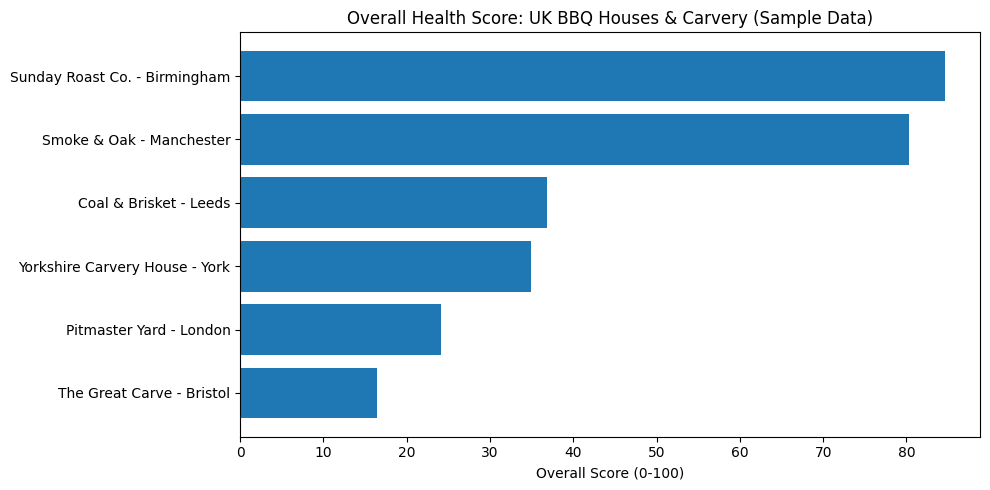

<Figure size 800x500 with 0 Axes>

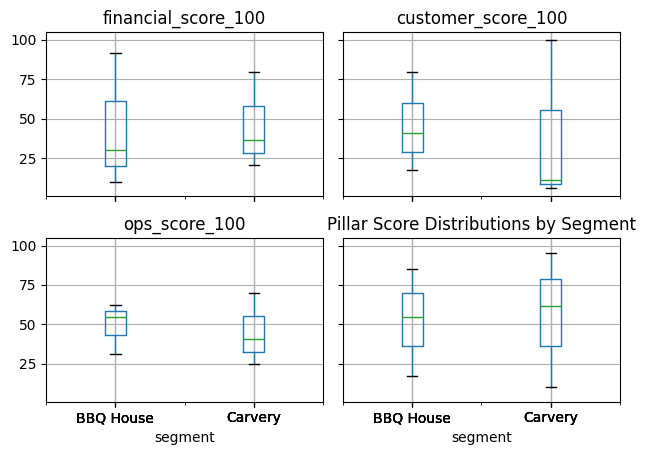

In [7]:
# ===================================================================================
# Notebook Cell 7: Visualisations (simple, no custom colors)
# ===================================================================================
# 1) Overall scores bar chart
plot_df = scoring.sort_values("overall_score_100", ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(plot_df["business"], plot_df["overall_score_100"])
plt.xlabel("Overall Score (0-100)")
plt.title("Overall Health Score: UK BBQ Houses & Carvery (Sample Data)")
plt.tight_layout()
plt.show()

# 2) Pillar scores by segment (boxplots)
plt.figure(figsize=(8, 5))
scoring.boxplot(column=["financial_score_100","customer_score_100","ops_score_100","people_score_100"], by="segment")
plt.title("Pillar Score Distributions by Segment")
plt.suptitle("")
plt.ylabel("Score (0-100)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [8]:
# ===================================================================================
# Notebook Cell 8: Drill-down table for a single business
# ===================================================================================
def business_report(df_scored, name):
    row = df_scored[df_scored["business"] == name]
    if row.empty:
        raise ValueError(f"Business '{name}' not found. Try one from df_scored['business'].unique()")
    row = row.iloc[0]

    report = {
        "Business": row["business"],
        "Segment": row["segment"],
        "Overall Score (0-100)": round(row["overall_score_100"], 2),

        # Financial
        "Profit Margin %": round(row["profit_margin_pct"], 2),
        "Cash Flow Coverage (OpCF/Opex)": round(row["cash_flow_coverage"], 2),
        "Current Ratio": round(row["current_ratio"], 2),
        "Recurring Revenue %": round(row["recurring_rev_pct"], 2),

        # Customer/Market
        "NPS": round(row["nps"], 1),
        "Churn %": round(row["churn_pct"], 2),
        "Reputation (0-10)": round(row["reputation_score_10"], 2),
        "Market Share Growth %": round(row["market_share_growth_pct"], 2),
        "UVP (0-10)": round(row["uvp_score_10"], 2),

        # Ops/Strategy
        "Waste %": round(row["waste_pct"], 2),
        "Labour %": round(row["labour_pct"], 2),
        "Table Turns / Day": round(row["table_turns_per_day"], 2),
        "KPI Maturity (0-10)": round(row["kpi_maturity_10"], 2),
        "Adaptability (0-10)": round(row["adaptability_10"], 2),

        # People/Culture
        "Engagement (0-10)": round(row["engagement_10"], 2),
        "Annual Turnover %": round(row["annual_turnover_pct"], 2),
        "Training Hours / Employee": int(row["training_hours_per_employee"]),
        "Leadership (0-10)": round(row["leadership_10"], 2),
    }

    return pd.DataFrame([report])

# Example usage:
business_report(scoring, "Smoke & Oak - Manchester")


,Business,Segment,Overall Score (0-100),Profit Margin %,Cash Flow Coverage (OpCF/Opex),Current Ratio,Recurring Revenue %,NPS,Churn %,Reputation (0-10),Market Share Growth %,UVP (0-10),Waste %,Labour %,Table Turns / Day,KPI Maturity (0-10),Adaptability (0-10),Engagement (0-10),Annual Turnover %,Training Hours / Employee,Leadership (0-10)
0,Smoke & Oak - Manchester,BBQ House,80.29,8.89,0.26,1.58,13.33,61.5,6.82,8.6,2.1,8.0,5.2,29.0,2.7,7.0,8.0,7.8,18.0,22,8.2


In [9]:
# ===================================================================================
# Notebook Cell 9: Export results (CSV)
# ===================================================================================
# Save the scored table for reporting
scoring.to_csv("uk_bbq_carvery_kpi_scoring.csv", index=False)
print("Saved: uk_bbq_carvery_kpi_scoring.csv")


Saved: uk_bbq_carvery_kpi_scoring.csv
